In [2]:
!git clone https://github.com/Leejunho123/deep-learning-from-scratch-3.git
%cd /content/deep-learning-from-scratch-3

Cloning into 'deep-learning-from-scratch-3'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 2104 (delta 1), reused 0 (delta 0), pack-reused 2097
Receiving objects: 100% (2104/2104), 34.94 MiB | 21.53 MiB/s, done.
Resolving deltas: 100% (1445/1445), done.
/content/deep-learning-from-scratch-3


## 60 LSTM과 데이터 로더

### 60.1 시계열 데이터용 데이터 로더

+ 시계열 데이터는 시간의 순서가 중요하기 때문에 배치를 할 때도 연속된 시간 순으로 배치를 분리한다.
+ 미니 배치 만들기

In [11]:
import dezero
from dezero import DataLoader
import numpy as np
class SeqDataLoader(DataLoader):
  def __init__(self, dataset, batch_size, gpu=False):
    super().__init__(dataset=dataset, batch_size=batch_size, shuffle=False, gpu=gpu)

    
  def __next__(self):
    if self.iteration >= self.max_iter:
      self.reset()
      raise StopIteration

    jump = self.data_size // self.batch_size
    batch_index = [ (i * jump + self.iteration) % self.data_size for i in range(self.batch_size)]
    batch = [self.dataset[i] for i in batch_index]

    xp = cuda.cupy if self.gpu else np
    x = xp.array([example[0] for example in batch])
    t = xp.array([example[1] for example in batch])

    self.iteration += 1
    return x, t


In [12]:
train_set = dezero.datasets.SinCurve(train=True)
#batch_size 3
dataloader = SeqDataLoader(train_set, batch_size=3)
x, t =next(dataloader)

print(x)
print('-------------')
print(t)

# 3개씩 나눠진 모습

[[-0.01966759]
 [ 0.82332891]
 [-0.87142762]]
-------------
[[ 0.00374738]
 [ 0.8667332 ]
 [-0.88793571]]


### 60.2 LSTM 계층 구현

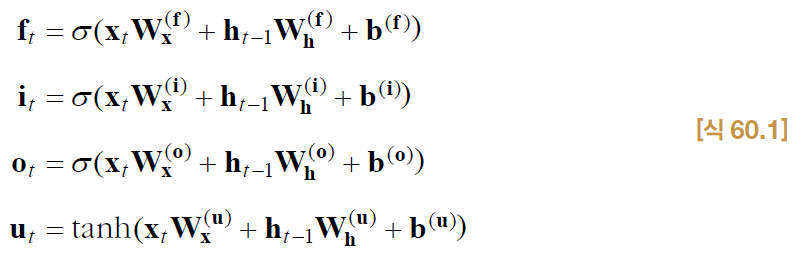

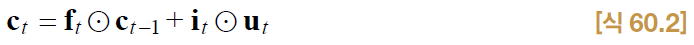

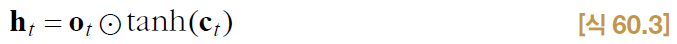

+ 은닉 상태 h 외에도 기억 셀 c를 사용
+ image.png : 아다마르 곱, 같은 크기의 두 행렬의 각 성분을 곱하는 연산

In [14]:
from dezero import Layer
class LSTM(Layer):
    def __init__(self, hidden_size, in_size=None):
        super().__init__()

        H, I = hidden_size, in_size
        self.x2f = Linear(H, in_size=I)
        self.x2i = Linear(H, in_size=I)
        self.x2o = Linear(H, in_size=I)
        self.x2u = Linear(H, in_size=I)
        self.h2f = Linear(H, in_size=H, nobias=True)
        self.h2i = Linear(H, in_size=H, nobias=True)
        self.h2o = Linear(H, in_size=H, nobias=True)
        self.h2u = Linear(H, in_size=H, nobias=True)
        self.reset_state()

    def reset_state(self):
        self.h = None
        self.c = None

    def forward(self, x):
        if self.h is None:
            f = F.sigmoid(self.x2f(x))
            i = F.sigmoid(self.x2i(x))
            o = F.sigmoid(self.x2o(x))
            u = F.tanh(self.x2u(x))
        else:
            f = F.sigmoid(self.x2f(x) + self.h2f(self.h))
            i = F.sigmoid(self.x2i(x) + self.h2i(self.h))
            o = F.sigmoid(self.x2o(x) + self.h2o(self.h))
            u = F.tanh(self.x2u(x) + self.h2u(self.h))

        if self.c is None:
            c_new = (i * u)
        else:
            c_new = (f * self.c) + (i * u)

        h_new = o * F.tanh(c_new)

        self.h, self.c = h_new, c_new
        return h_new

In [15]:
import numpy as np
import dezero
from dezero import Model
from dezero import SeqDataLoader
import dezero.functions as F
import dezero.layers as L

max_epoch = 100
batch_size = 30
hidden_size = 100
bptt_length = 30

train_set = dezero.datasets.SinCurve(train=True)

dataloader = SeqDataLoader(train_set, batch_size = batch_size)
seqlen = len(train_set)

class BetterRNN(Model):
  def __init__(self, hidden_size, out_size):
    super().__init__()
    self.rnn = L.LSTM(hidden_size)
    self.fc = L.Linear(out_size)

  def reset_state(self):
    self.rnn.reset_state()

  def forward(self, x):
    y = self.rnn(x)
    y = self.fc(y)
    return y

model = BetterRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)





In [17]:
for epoch in range(max_epoch):
  model.reset_state()
  loss, count = 0, 0
  for x, t in dataloader:
    y = model(x)
    loss += F.mean_squared_error(y,t)
    count += 1
    if count % bptt_length == 0 or count == seqlen:
      model.cleargrads()
      loss.backward()
      loss.unchain_backward()
      optimizer.update()

  avg_loss = float(loss.data) / count
  print('| epoch %d | loss %f' % (epoch+1, avg_loss))
  

| epoch 1 | loss 0.016735
| epoch 2 | loss 0.011273
| epoch 3 | loss 0.011194
| epoch 4 | loss 0.011108
| epoch 5 | loss 0.011012
| epoch 6 | loss 0.010904
| epoch 7 | loss 0.010789
| epoch 8 | loss 0.010671
| epoch 9 | loss 0.010558
| epoch 10 | loss 0.010453
| epoch 11 | loss 0.010359
| epoch 12 | loss 0.010275
| epoch 13 | loss 0.010199
| epoch 14 | loss 0.010127
| epoch 15 | loss 0.010056
| epoch 16 | loss 0.009982
| epoch 17 | loss 0.009905
| epoch 18 | loss 0.009825
| epoch 19 | loss 0.009743
| epoch 20 | loss 0.009662
| epoch 21 | loss 0.009583
| epoch 22 | loss 0.009508
| epoch 23 | loss 0.009438
| epoch 24 | loss 0.009371
| epoch 25 | loss 0.009307
| epoch 26 | loss 0.009245
| epoch 27 | loss 0.009183
| epoch 28 | loss 0.009120
| epoch 29 | loss 0.009057
| epoch 30 | loss 0.008994
| epoch 31 | loss 0.008933
| epoch 32 | loss 0.008872
| epoch 33 | loss 0.008813
| epoch 34 | loss 0.008756
| epoch 35 | loss 0.008700
| epoch 36 | loss 0.008646
| epoch 37 | loss 0.008591
| epoch 38

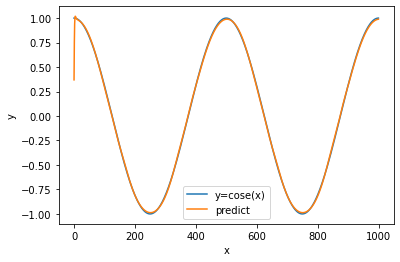

In [18]:
import matplotlib.pyplot as plt

xs = np.cos(np.linspace(0,4*np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
  for x in xs:
    x = np.array(x).reshape(1,1)
    y = model(x)
    pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)),xs,label='y=cose(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()